# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

data_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


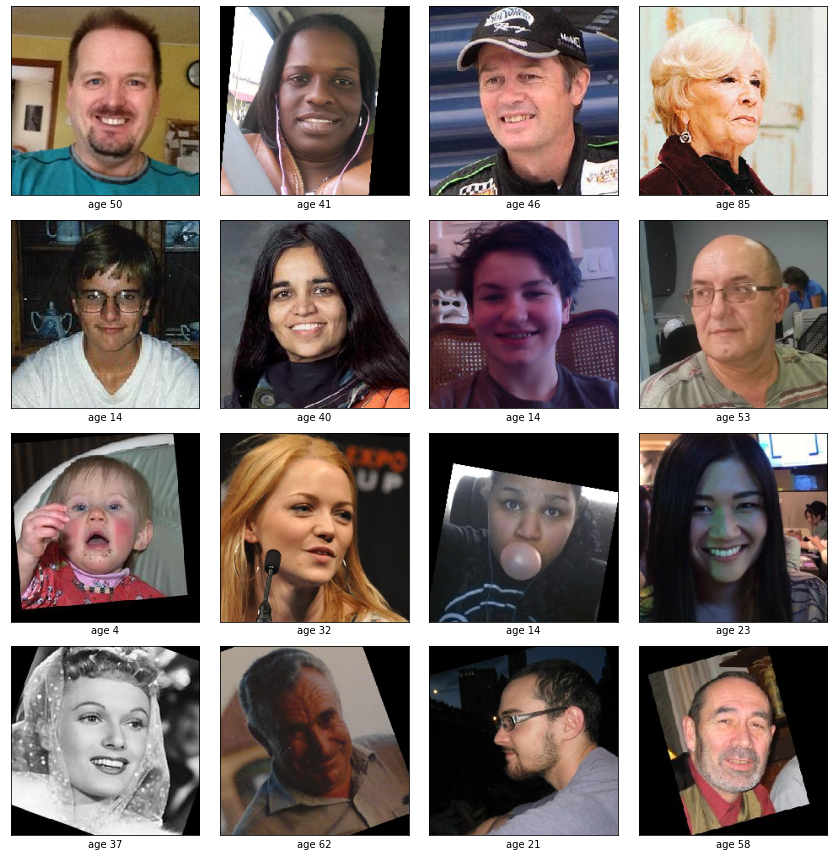

In [3]:
features, target = next(data_gen_flow)

fig = plt.figure(figsize=(12, 12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    
    plt.imshow(features[i])
    plt.xlabel(f'age {target[i]}')
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Предварительная аугментация была уже проведена. Нет необходимости в предобработке.

In [35]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [36]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Нет пропусков в данных

In [37]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels['real_age'].median()

29.0

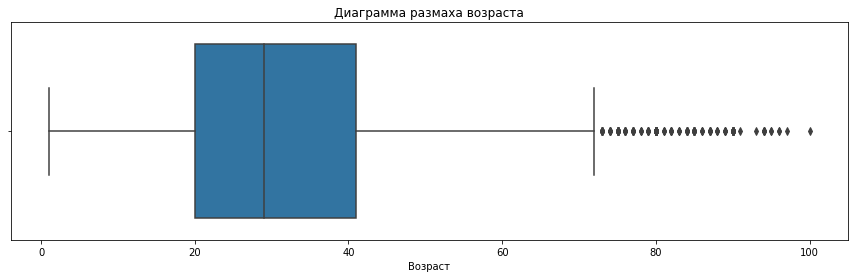

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))

sns.boxplot(x=labels['real_age'])

ax.set_title('Диаграмма размаха возраста')
ax.set_xlabel('Возраст');

Большинство фотографий людей возрастом от 20 до 40.

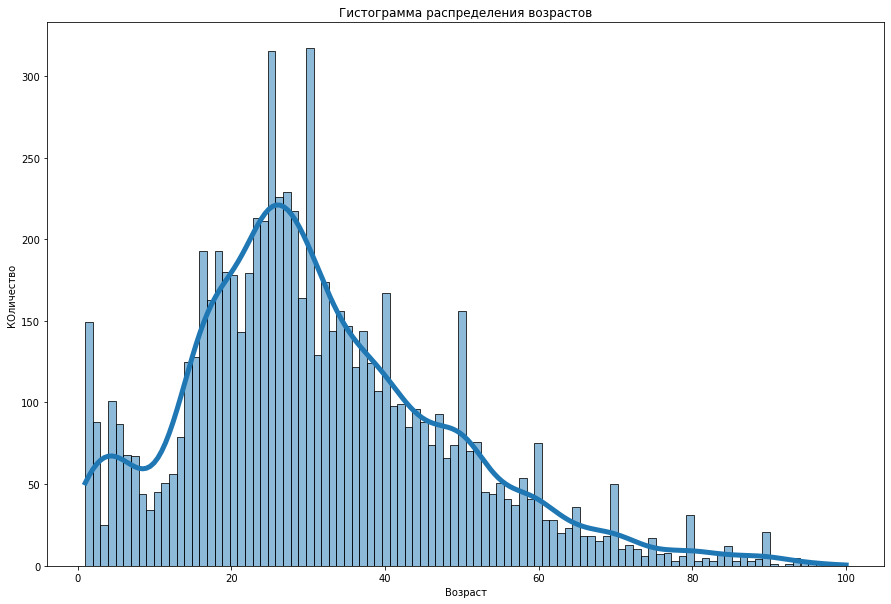

In [5]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.histplot(x=labels['real_age'], kde=True, line_kws={'linewidth':5}, bins=100)

ax.set_title('Гистограмма распределения возрастов')
ax.set_xlabel('Возраст')
ax.set_ylabel('КОличество');

Вывод:

- Мы располагаем 7591 изображениями люедй разных возрастов, чего по моему мнению должно быть достаточно для нашей задачи.
- Исходя из диаграммы разброса, большинство фотографий людей возрастом от 20 до 40.
- До 30 возраста распределены нормально, но после заметны явные всплески значений на десятках. Похоже разметчики склонны округлять значения до десятков, потому что с возрастом сложнее точно определять цифру.
- Фотографии все разного качества, разной цветовой палитры. 
- Фото были обработаны так, чтобы лицо не было наклонено, но где-то алгоритм не смог сделать это правильно, потому появляются немногочисленные аномалии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1. / 255)

    data = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        class_mode="raw",
        subset='training',
        shuffle=True,
        seed=12345)
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1. / 255)

    data = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```
Train for 190 steps, validate for 48 steps
Epoch 1/8
190/190 - 58s - loss: 271.5619 - mae: 11.8054 - val_loss: 1034.2428 - val_mae: 27.3854
Epoch 2/8
190/190 - 35s - loss: 65.8004 - mae: 6.1679 - val_loss: 937.3808 - val_mae: 25.5906
Epoch 3/8
190/190 - 35s - loss: 30.7131 - mae: 4.2731 - val_loss: 233.6350 - val_mae: 11.6968
Epoch 4/8
190/190 - 35s - loss: 19.7130 - mae: 3.3845 - val_loss: 117.6640 - val_mae: 8.1268
Epoch 5/8
190/190 - 35s - loss: 14.9848 - mae: 3.0007 - val_loss: 78.2330 - val_mae: 6.7623
Epoch 6/8
190/190 - 34s - loss: 11.1209 - mae: 2.5949 - val_loss: 77.1517 - val_mae: 6.4827
Epoch 7/8
190/190 - 35s - loss: 10.1697 - mae: 2.4321 - val_loss: 79.5493 - val_mae: 6.9827
Epoch 8/8
190/190 - 35s - loss: 9.2637 - mae: 2.3127 - val_loss: 72.3046 - val_mae: 6.3602

48/48 - 7s - loss: 72.3046 - mae: 6.3602
Test MAE: 6.3602
```

## Анализ обученной модели

Мы сделали модель, в основе которой лежит предобученную на ImageNet модель ResNet, и сумели достичь MAE 6.4, что соответсвует требованиям.